# Importing needed modules

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style

from sklearn.preprocessing import LabelEncoder # for encoding categorical variables

# importing classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier

import sklearn.metrics
from sklearn.model_selection import (cross_validate, KFold)

import optuna # for hyperparameter optimization

from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay
import shap

import logging

# Module Configuration

In [2]:
# Rest of the code
pd.set_option('display.max_columns', None)
shap.initjs()

# Loading Data
We first load the data and briefly look at it.

In [3]:
# Load the data
data = pd.read_csv('german_raw.csv')

print("# Data:")
display(data)

print("# Data description:")
display(data.describe())

print()

print("# Unencoded categorical variables:")
for column in data.select_dtypes(include=['object']):
    print(f"{column}: {data[column].unique()}")

print()

# This was an attemped to find already encoded categorical variables; however, it did not work, as a lot of the non-categorical columns have less than 10 unique values.
# 
# print("# Encoded categorical variables:")
# for column in data:
#     if len(data[column].unique()) <= 10:
#         print(f"{column}: {data[column].unique()}")

# Data:


,GoodCustomer,Gender,ForeignWorker,Single,Age,LoanDuration,PurposeOfLoan,LoanAmount,LoanRateAsPercentOfIncome,YearsAtCurrentHome,NumberOfOtherLoansAtBank,NumberOfLiableIndividuals,HasTelephone,CheckingAccountBalance_geq_0,CheckingAccountBalance_geq_200,SavingsAccountBalance_geq_100,SavingsAccountBalance_geq_500,MissedPayments,NoCurrentLoan,CriticalAccountOrLoansElsewhere,OtherLoansAtBank,OtherLoansAtStore,HasCoapplicant,HasGuarantor,OwnsHouse,RentsHouse,Unemployed,YearsAtCurrentJob_lt_1,YearsAtCurrentJob_geq_4,JobClassIsSkilled
0,1,Male,0,1,67,6,Electronics,1169,4,4,2,1,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,1
1,-1,Female,0,0,22,48,Electronics,5951,2,2,1,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
2,1,Male,0,1,49,12,Education,2096,2,3,1,2,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0
3,1,Male,0,1,45,42,Furniture,7882,2,4,1,2,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1
4,-1,Male,0,1,53,24,NewCar,4870,3,4,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,Female,0,0,31,12,Furniture,1736,3,4,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
996,1,Male,0,0,40,30,UsedCar,3857,4,4,1,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
997,1,Male,0,1,38,12,Electronics,804,4,4,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1
998,-1,Male,0,1,23,45,Electronics,1845,4,4,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


# Data description:


,GoodCustomer,ForeignWorker,Single,Age,LoanDuration,LoanAmount,LoanRateAsPercentOfIncome,YearsAtCurrentHome,NumberOfOtherLoansAtBank,NumberOfLiableIndividuals,HasTelephone,CheckingAccountBalance_geq_0,CheckingAccountBalance_geq_200,SavingsAccountBalance_geq_100,SavingsAccountBalance_geq_500,MissedPayments,NoCurrentLoan,CriticalAccountOrLoansElsewhere,OtherLoansAtBank,OtherLoansAtStore,HasCoapplicant,HasGuarantor,OwnsHouse,RentsHouse,Unemployed,YearsAtCurrentJob_lt_1,YearsAtCurrentJob_geq_4,JobClassIsSkilled
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000
mean,0.400000,0.037000,0.54800,35.546000,20.903000,3271.258000,2.973000,2.845000,1.407000,1.155000,0.404000,0.332000,0.063000,0.214000,0.111000,0.912000,0.049000,0.293000,0.13900,0.0,0.041000,0.052000,0.713000,0.179000,0.062000,0.172000,0.42700,0.778000
std,0.916974,0.188856,0.49794,11.375469,12.058814,2822.736876,1.118715,1.103718,0.577654,0.362086,0.490943,0.471167,0.243085,0.410332,0.314289,0.283437,0.215976,0.455366,0.34612,0.0,0.198389,0.222138,0.452588,0.383544,0.241276,0.377569,0.49489,0.415799
min,-1.000000,0.000000,0.00000,19.000000,4.000000,250.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,-1.000000,0.000000,0.00000,27.000000,12.000000,1365.500000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000
50%,1.000000,0.000000,1.00000,33.000000,18.000000,2319.500000,3.000000,3.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,1.000000
75%,1.000000,0.000000,1.00000,42.000000,24.000000,3972.250000,4.000000,4.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.00000,1.000000
max,1.000000,1.000000,1.00000,75.000000,72.000000,18424.000000,4.000000,4.000000,4.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000



# Unencoded categorical variables:
Gender: ['Male' 'Female']
PurposeOfLoan: ['Electronics' 'Education' 'Furniture' 'NewCar' 'UsedCar' 'Business'
 'HomeAppliances' 'Repairs' 'Other' 'Retraining']



# Prep Work

### Encoding

At this step, we must make sure the categorical data is properly encoded. In this dataset, some of the categorical features are already properly encoded (such as ForeignWorker, or Single), some of them were poorly encoded (such as GoodCustomer), and some of them weren't encoded at all (such as Gender and PurposeOfLoan). We must make sure they're all properly encoded, that is, each category is mapped to the first non-negative integer that wasn't already used by another category of the same feature (i.e. starting at 0 and incrementing it for each new category that appears).

In [5]:
## Fixing poorly encoded categorical variables:

encoded_data = data.copy()

label_encoder = LabelEncoder()
poorly_encoded_columns = ["Gender", "PurposeOfLoan", "GoodCustomer"]

print("[COLUMN]: {[ORIGINAL_VALUE]: [ENCODED_VALUE]}")
for column in poorly_encoded_columns:
    encoded_data[column] = label_encoder.fit_transform(data[column])                        # Using LabelEncoder from sklearn.preprocessing
    print(f"{column}: {dict(zip(data[column].unique(), encoded_data[column].unique()))}")   # Displaying mapping made by LabelEncoder   


display(encoded_data)
encoded_data.to_csv('german_encoded.csv', index=False)

[COLUMN]: {[ORIGINAL_VALUE]: [ENCODED_VALUE]}
Gender: {'Male': 1, 'Female': 0}
PurposeOfLoan: {'Electronics': 2, 'Education': 1, 'Furniture': 3, 'NewCar': 5, 'UsedCar': 9, 'Business': 0, 'HomeAppliances': 4, 'Repairs': 7, 'Other': 6, 'Retraining': 8}
GoodCustomer: {1: 1, -1: 0}


,GoodCustomer,Gender,ForeignWorker,Single,Age,LoanDuration,PurposeOfLoan,LoanAmount,LoanRateAsPercentOfIncome,YearsAtCurrentHome,NumberOfOtherLoansAtBank,NumberOfLiableIndividuals,HasTelephone,CheckingAccountBalance_geq_0,CheckingAccountBalance_geq_200,SavingsAccountBalance_geq_100,SavingsAccountBalance_geq_500,MissedPayments,NoCurrentLoan,CriticalAccountOrLoansElsewhere,OtherLoansAtBank,OtherLoansAtStore,HasCoapplicant,HasGuarantor,OwnsHouse,RentsHouse,Unemployed,YearsAtCurrentJob_lt_1,YearsAtCurrentJob_geq_4,JobClassIsSkilled
0,1,1,0,1,67,6,2,1169,4,4,2,1,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,1
1,0,0,0,0,22,48,2,5951,2,2,1,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
2,1,1,0,1,49,12,1,2096,2,3,1,2,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0
3,1,1,0,1,45,42,3,7882,2,4,1,2,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1
4,0,1,0,1,53,24,5,4870,3,4,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,0,0,0,31,12,3,1736,3,4,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
996,1,1,0,0,40,30,9,3857,4,4,1,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
997,1,1,0,1,38,12,2,804,4,4,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1
998,0,1,0,1,23,45,2,1845,4,4,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


### Looking at proportions
Determining how balanced or unbalanced the dataset is

In [5]:
# Display proportion of good customers
print("# Proportion of good customers:")
print(encoded_data["GoodCustomer"].value_counts(normalize=True))
print()

# Display proportion of males to females:s
print("# Proportion of males to females:")
print(encoded_data["Gender"].value_counts(normalize=True))
print()

# Display age distribution
print("# Age distribution:")
encoded_data['AgeGroup'] = pd.cut(encoded_data['Age'], bins=[0, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 100])
age_distribution = encoded_data['AgeGroup'].value_counts(normalize=True).sort_index() * 100
print(age_distribution)
encoded_data.drop('AgeGroup', axis=1, inplace=True)


# Proportion of good customers:
GoodCustomer
1    0.7
0    0.3
Name: proportion, dtype: float64

# Proportion of males to females:
Gender
1    0.69
0    0.31
Name: proportion, dtype: float64

# Age distribution:
AgeGroup
(0, 20]       1.6
(20, 25]     17.4
(25, 30]     22.1
(30, 35]     17.7
(35, 40]     13.8
(40, 45]      8.8
(45, 50]      7.3
(50, 55]      4.2
(55, 60]      2.6
(60, 65]      2.7
(65, 100]     1.8
Name: proportion, dtype: float64


There are way more good customers than bad customers. The gender and age distributions are also skewed. The dataset is thus unbalanced. This should be taken into account when evaluating the models.

### Looking at correlations

In [7]:
display(encoded_data.corr())

# Select high correlations:
correlation_threshold = 0.4
high_correlations = encoded_data.corr().unstack().sort_values(ascending=False).drop_duplicates().where(lambda x: abs(x) > correlation_threshold).dropna()

print(high_correlations)

,GoodCustomer,Gender,ForeignWorker,Single,Age,LoanDuration,PurposeOfLoan,LoanAmount,LoanRateAsPercentOfIncome,YearsAtCurrentHome,NumberOfOtherLoansAtBank,NumberOfLiableIndividuals,HasTelephone,CheckingAccountBalance_geq_0,CheckingAccountBalance_geq_200,SavingsAccountBalance_geq_100,SavingsAccountBalance_geq_500,MissedPayments,NoCurrentLoan,CriticalAccountOrLoansElsewhere,OtherLoansAtBank,OtherLoansAtStore,HasCoapplicant,HasGuarantor,OwnsHouse,RentsHouse,Unemployed,YearsAtCurrentJob_lt_1,YearsAtCurrentJob_geq_4,JobClassIsSkilled
GoodCustomer,1.000000,0.075493,0.082079,0.080677,0.091127,-0.214927,0.044030,-0.154739,-0.072404,-0.002967,0.045732,0.003015,0.036466,-0.089895,0.044009,0.070234,0.113231,0.012325,-0.134448,0.181713,-0.096510,NaN,-0.062728,0.055039,0.134589,-0.092785,-0.039815,-0.106397,0.110732,-0.018903
Gender,0.075493,1.000000,0.051202,0.738036,0.161694,0.081432,0.029852,0.093482,0.086302,-0.013818,0.094260,0.203431,0.075966,-0.014141,-0.004183,-0.003480,-0.004061,-0.086092,-0.018129,0.056200,0.019313,NaN,0.007742,0.010907,0.119638,-0.222845,-0.033891,-0.187239,0.167724,0.037355
ForeignWorker,0.082079,0.051202,1.000000,0.028996,-0.006151,-0.138196,0.065120,-0.050050,-0.090024,-0.054097,-0.009717,0.077071,-0.107401,-0.036943,0.036392,0.001059,-0.001805,0.060888,-0.019952,0.036770,-0.002190,NaN,0.066338,0.097256,0.018960,0.032849,-0.050394,0.037004,-0.040688,-0.099251
Single,0.080677,0.738036,0.028996,1.000000,0.207434,0.121889,0.060168,0.152458,0.118233,0.063639,0.118198,0.283483,0.080290,-0.059460,-0.012603,-0.030728,-0.024485,-0.076429,0.010685,0.090218,0.033849,NaN,0.025657,-0.004489,0.076736,-0.225860,-0.016464,-0.224983,0.223431,0.037015
Age,0.091127,0.161694,-0.006151,0.207434,1.000000,-0.036136,0.071914,0.032716,0.058266,0.266419,0.149254,0.118201,0.145259,-0.054212,0.037504,-0.020768,0.045748,-0.016129,0.014360,0.163681,0.046552,NaN,-0.018357,-0.023923,0.006553,-0.212620,0.110562,-0.209967,0.254599,-0.063233
LoanDuration,-0.214927,0.081432,-0.138196,0.121889,-0.036136,1.000000,0.010539,0.624984,0.074749,0.034067,-0.011284,-0.023834,0.164718,0.044786,-0.076455,-0.010771,-0.063978,-0.136927,0.033728,-0.075575,0.035851,NaN,0.029698,-0.039594,-0.075169,-0.064417,-0.005156,-0.056792,0.076389,0.189950
PurposeOfLoan,0.044030,0.029852,0.065120,0.060168,0.071914,0.010539,1.000000,0.166952,-0.093390,0.123992,-0.000393,0.090675,0.066549,-0.085077,-0.064652,-0.013117,0.003596,0.072132,0.010664,0.053558,-0.021635,NaN,0.001130,-0.021453,-0.119367,0.023121,0.120312,-0.034219,0.023694,0.021324
LoanAmount,-0.154739,0.093482,-0.050050,0.152458,0.032716,0.624984,0.166952,1.000000,-0.271316,0.028926,0.020795,0.017142,0.276995,0.060775,-0.100510,-0.056976,-0.087494,-0.113552,0.005923,-0.041807,0.039474,NaN,0.079076,-0.065237,-0.117497,-0.024611,0.086159,-0.051502,0.032745,0.165560
LoanRateAsPercentOfIncome,-0.072404,0.086302,-0.090024,0.118233,0.058266,0.074749,-0.093390,-0.271316,1.000000,0.049302,0.021669,-0.071207,0.014413,-0.070334,-0.041591,-0.007026,0.005685,0.014597,0.030339,0.041089,-0.016150,NaN,-0.013048,-0.006429,0.049922,-0.091373,-0.049420,-0.034021,0.116671,0.086091
YearsAtCurrentHome,-0.002967,-0.013818,-0.054097,0.063639,0.266419,0.034067,0.123992,0.028926,0.049302,1.000000,0.089625,0.042643,0.095359,-0.085734,-0.064303,0.031319,0.023677,0.020351,0.027694,0.088460,0.014530,NaN,0.001623,-0.028334,-0.297547,0.167285,0.036123,-0.164155,0.242242,0.003468


GoodCustomer                     GoodCustomer                     1.000000
Gender                           Single                           0.738036
SavingsAccountBalance_geq_500    SavingsAccountBalance_geq_100    0.677197
LoanAmount                       LoanDuration                     0.624984
CriticalAccountOrLoansElsewhere  NumberOfOtherLoansAtBank         0.501364
RentsHouse                       OwnsHouse                       -0.735968
dtype: float64


# Model Selection
Now, we must select a model to which to fit the data.

1. First, we'll start by deciding which classifiers will be tested.
1. Then, we decide which metrics will be used to score the classifiers.
1. Next, we'll perform K-Fold cross-validation on each model to determine an estimate for each of the metrics.
1. Finally, we'll select the best performing model according to those metrics and the project's particularities.


### Defining X and y matrices 

In [6]:
X = encoded_data.drop(columns=["GoodCustomer"])
y = encoded_data["GoodCustomer"]

### Defining evaluation metrics and methods

In [7]:
CLASSIFICATION_METRICS = ['balanced_accuracy', 'roc_auc', 'accuracy', 'precision', 'recall', 'f1'] # a few useful selected metrics for the classification setting.

def cross_validate_models(list_of_models, X, y, cv, scoring_metrics):
    """
    Tests and scores a list of sklearn models using cross-validation.

    :param list_of_models: A list of sklearn models.
    :param X: The feature matrix.
    :param y: The target vector.
    :param cv: The cross-validation strategy.
    :param scoring: A list of metrics to score the models on (see https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values for how the scoring list should be built).
    :return: a DataFrame with the results. The results are averaged over the number of folds in cv.
    """

    results = []
    for model in list_of_models:
        # print(f"[cross_validate_models()]: Cross-validating model: {type(model).__name__}")
        
        cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring_metrics)
        results.append(pd.DataFrame(cv_results).mean().rename(type(model).__name__))
        
    df_results = pd.DataFrame(results) # Compiles the results into a DataFrame
    df_results.rename(columns=lambda x: "avg_" + x.replace('test_', ''), inplace=True) # remove 'test_' from column names and add 'avg_' to the beginning
    return df_results

### Evaluating models

##### Without Hyperparameter Tuning

In [10]:
# Models to test:
untuned_models = [
    LogisticRegression(max_iter=10000), RandomForestClassifier(), LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(), GaussianNB(), xgb.XGBClassifier(), KNeighborsClassifier(n_neighbors=10)
]

cross_validate_models(untuned_models, X, y, KFold(n_splits=10, shuffle=True), scoring_metrics=CLASSIFICATION_METRICS)

/home/everton/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:949: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/everton/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:949: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/everton/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:949: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/everton/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:949: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/everton/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:949: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/everton/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:949: UserWarning: Variables are collinear
  warnings.warn("Variables are coll

,avg_fit_time,avg_score_time,avg_balanced_accuracy,avg_roc_auc,avg_accuracy,avg_precision,avg_recall,avg_f1
LogisticRegression,0.590196,0.009419,0.600201,0.718049,0.722,0.749628,0.904108,0.819048
RandomForestClassifier,0.098722,0.010081,0.628162,0.737295,0.744,0.763014,0.921762,0.834107
LinearDiscriminantAnalysis,0.002858,0.007727,0.602707,0.711931,0.724,0.752675,0.901462,0.819840
QuadraticDiscriminantAnalysis,0.007108,0.009191,0.632525,0.713687,0.699,0.775296,0.799365,0.784353
GaussianNB,0.001992,0.007975,0.639829,0.714791,0.679,0.790062,0.736641,0.761765
XGBClassifier,0.127255,0.038673,0.623564,0.719487,0.705,0.769052,0.823968,0.794673
KNeighborsClassifier,0.001896,0.024182,0.540900,0.567693,0.659,0.720196,0.840436,0.773401


##### With Hyperparameter Tuning
Tuning the models' hyperparameters with optuna

- Defining objective functions for each of the models being tested:

In [13]:
def logisticregression_objective(trial: optuna.Trial) -> list[float]:
    params = {
        "C": trial.suggest_float("C", 1e-5, 1e4),
        "penalty": 'l2', # trial.suggest_categorical("penalty", ["l1", "l2", "elasticnet"]),
        "solver": "lbfgs", # trial.suggest_categorical("solver", ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"]),
        "max_iter": 10000
    }

    # # Handling the solver parameter, as it is somewhat dependent on the penalty parameter
    # valid_solvers = []
    # if params["penalty"] == "l1":
    #     valid_solvers = ["liblinear", "saga"]
    # elif params["penalty"] == "l2":
    #     valid_solvers = ["lbfgs", "newton-cg", "sag", "saga"]
    # elif params["penalty"] == "elasticnet":
    #     valid_solvers = ["saga"]
    # else:
    #     valid_solvers = ["lbfgs", "newton-cg", "sag", "saga"]
    
    # if params["solver"] not in valid_solvers:
    #     return [0.0 for _ in CLASSIFICATION_METRICS]


    model = LogisticRegression(**params)
    cv_results = cross_validate(model, X, y, cv=KFold(n_splits=10, shuffle=True), scoring=CLASSIFICATION_METRICS)

    return [cv_results[f"test_{metric}"].mean() for metric in CLASSIFICATION_METRICS]


def randomforestclassifier_objective(trial: optuna.Trial) -> list[float]:
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 1, 1000),
        "max_depth": trial.suggest_int("max_depth", 1, 100),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
    }
    model = RandomForestClassifier(**params)
    cv_results = cross_validate(model, X, y, cv=KFold(n_splits=10, shuffle=True), scoring=CLASSIFICATION_METRICS)

    return [cv_results[f"test_{metric}"].mean() for metric in CLASSIFICATION_METRICS]


def lda_objective(trial: optuna.Trial) -> list[float]:
    params = {
        "solver": trial.suggest_categorical("solver", ["svd", "lsqr", "eigen"]),
        "shrinkage": trial.suggest_float("shrinkage", 0.0, 1.0),
    }
    model = LinearDiscriminantAnalysis(**params)
    cv_results = cross_validate(model, X, y, cv=KFold(n_splits=10, shuffle=True), scoring=CLASSIFICATION_METRICS)

    return [cv_results[f"test_{metric}"].mean() for metric in CLASSIFICATION_METRICS]


def qda_objective(trial: optuna.Trial) -> list[float]:
    params = {
        "reg_param": trial.suggest_float("reg_param", 0.0, 1.0),
    }
    model = QuadraticDiscriminantAnalysis(**params)
    cv_results = cross_validate(model, X, y, cv=KFold(n_splits=10, shuffle=True), scoring=CLASSIFICATION_METRICS)

    return [cv_results[f"test_{metric}"].mean() for metric in CLASSIFICATION_METRICS]


def gaussian_nb_objective(trial: optuna.Trial) -> list[float]:
    params = {
        "var_smoothing": trial.suggest_float("var_smoothing", 1e-10, 1e-1),
    }
    model = GaussianNB(**params)
    cv_results = cross_validate(model, X, y, cv=KFold(n_splits=10, shuffle=True), scoring=CLASSIFICATION_METRICS)

    return [cv_results[f"test_{metric}"].mean() for metric in CLASSIFICATION_METRICS]


def xgb_objective(trial: optuna.Trial) -> list[float]:
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 1, 1000),
        "max_depth": trial.suggest_int("max_depth", 1, 100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-10, 1e10),
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-10, 1e10),
        "alpha": trial.suggest_float("alpha", 1e-10, 1e10),
    }
    model = xgb.XGBClassifier(**params)
    cv_results = cross_validate(model, X, y, cv=KFold(n_splits=10, shuffle=True), scoring=CLASSIFICATION_METRICS)

    return [cv_results[f"test_{metric}"].mean() for metric in CLASSIFICATION_METRICS]


def knn_objective(trial: optuna.Trial) -> list[float]:
    params = {
        "n_neighbors": trial.suggest_int("n_neighbors", 1, 100),
        "weights": trial.suggest_categorical("weights", ["uniform", "distance"]),
        "algorithm": trial.suggest_categorical("algorithm", ["auto", "ball_tree", "kd_tree", "brute"]),
        "leaf_size": trial.suggest_int("leaf_size", 1, 100),
    }
    model = KNeighborsClassifier(**params)
    cv_results = cross_validate(model, X, y, cv=KFold(n_splits=10, shuffle=True), scoring=CLASSIFICATION_METRICS)

    return [cv_results[f"test_{metric}"].mean() for metric in CLASSIFICATION_METRICS]


In [ ]:
# Optuna study for Logistic Regression
study = optuna.create_study(directions=["maximize"]*len(CLASSIFICATION_METRICS))
study.optimize(logisticregression_objective, n_trials=100, n_jobs=2)

In [ ]:
study.best_trials[0].params
for trial in study.trials:
    # Print trial number:
    print(f"TRIAL {trial.number}")
    print(trial.params)
    for value in trial.values:
        print("%.2f" % value, end=" ")
    print() 

### Decision to skip hyperparameter optimization
Hyperparameter optimization was taking too long, so I decided to grab some of the already calculated study_dicts to see if they did that much of a difference. Looking at the German.ipynb notebook, the AUC metric of the XGB classifier had gone up to about 0.78 with the right parameters. However, that increase could only be reproduced in some training-validation set combinations; on average, the increase is negligible, as seen below: when using K-Fold cross-validation and averaging out the metrics, they are not too different from their values when the model wasn't tuned.

In [9]:
study_dict = {'learning_rate': 0.08730015238141663, 'max_depth': 8, 'subsample': 0.9885334531348575, 
              'colsample_bytree': 0.8860893884596323, 'gamma': 0.38560298254941716, 
              'reg_alpha': 0.44299387597591205, 'reg_lambda': 0.37110498550700155, 
              'min_child_weight': 0.9339053330213946} # Obtained from previous study
xg = xgb.XGBClassifier(**study_dict)

cross_validate_models([xg], X, y, KFold(n_splits=10, shuffle=True), scoring_metrics=CLASSIFICATION_METRICS)


,avg_fit_time,avg_score_time,avg_balanced_accuracy,avg_roc_auc,avg_accuracy,avg_precision,avg_recall,avg_f1
XGBClassifier,0.334827,0.037189,0.604993,0.726125,0.705,0.754377,0.859172,0.802097


### XGBClassifier was selected!
For having marginally better metrics overall

# Explanation Analysis

In [13]:
xg.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8860893884596323, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.38560298254941716,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08730015238141663,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=0.9339053330213946, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

### Partial Dependence Plots (PDPs)

{'grid_values': [array([ 708.41      ,  794.42868687,  880.44737374,  966.46606061,
         1052.48474747, 1138.50343434, 1224.52212121, 1310.54080808,
         1396.55949495, 1482.57818182, 1568.59686869, 1654.61555556,
         1740.63424242, 1826.65292929, 1912.67161616, 1998.69030303,
         2084.7089899 , 2170.72767677, 2256.74636364, 2342.76505051,
         2428.78373737, 2514.80242424, 2600.82111111, 2686.83979798,
         2772.85848485, 2858.87717172, 2944.89585859, 3030.91454545,
         3116.93323232, 3202.95191919, 3288.97060606, 3374.98929293,
         3461.0079798 , 3547.02666667, 3633.04535354, 3719.0640404 ,
         3805.08272727, 3891.10141414, 3977.12010101, 4063.13878788,
         4149.15747475, 4235.17616162, 4321.19484848, 4407.21353535,
         4493.23222222, 4579.25090909, 4665.26959596, 4751.28828283,
         4837.3069697 , 4923.32565657, 5009.34434343, 5095.3630303 ,
         5181.38171717, 5267.40040404, 5353.41909091, 5439.43777778,
         5525.45646

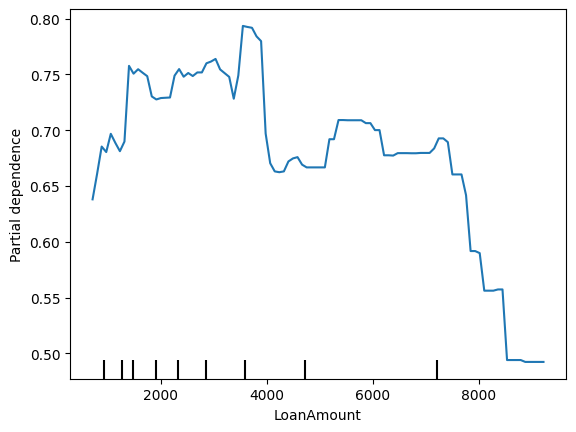

In [16]:
# Generate partial dependence plot for the best model
display(PartialDependenceDisplay.from_estimator(xg, X, features=["LoanAmount"]))
# display(PartialDependenceDisplay.from_estimator(xg, X, features=["LoanDuration"]))
# display(PartialDependenceDisplay.from_estimator(xg, X, features=["Age"]))
# display(PartialDependenceDisplay.from_estimator(xg, X, features=["Gender"], categorical_features=["Gender"]))
display(partial_dependence(xg, X, features=["LoanAmount"], kind='average'))

### SHAP

In [35]:
explainer = shap.Explainer(xg)
shap_values = explainer(X)

print("# SHAP values:")
shap_values[0]

# SHAP values:


.values =
array([ 0.02041479, -0.01388188,  0.02745067,  0.30706757,  0.96714574,
        0.25615305,  0.27557233, -0.17507824, -0.06867553, -0.0763512 ,
        0.01728544,  0.230584  ,  0.15398632,  0.0023317 , -0.00823405,
       -0.02191402,  0.01542904,  0.06821004,  1.0786576 ,  0.05957541,
        0.        ,  0.0202608 , -0.01456184,  0.08434071,  0.01516142,
        0.01234592,  0.08587773,  0.2791618 ,  0.01892339], dtype=float32)

.base_values =
0.8804363

.data =
array([   1,    0,    1,   67,    6,    2, 1169,    4,    4,    2,    1,
          1,    0,    0,    0,    0,    1,    0,    1,    0,    0,    0,
          0,    1,    0,    0,    0,    1,    1])

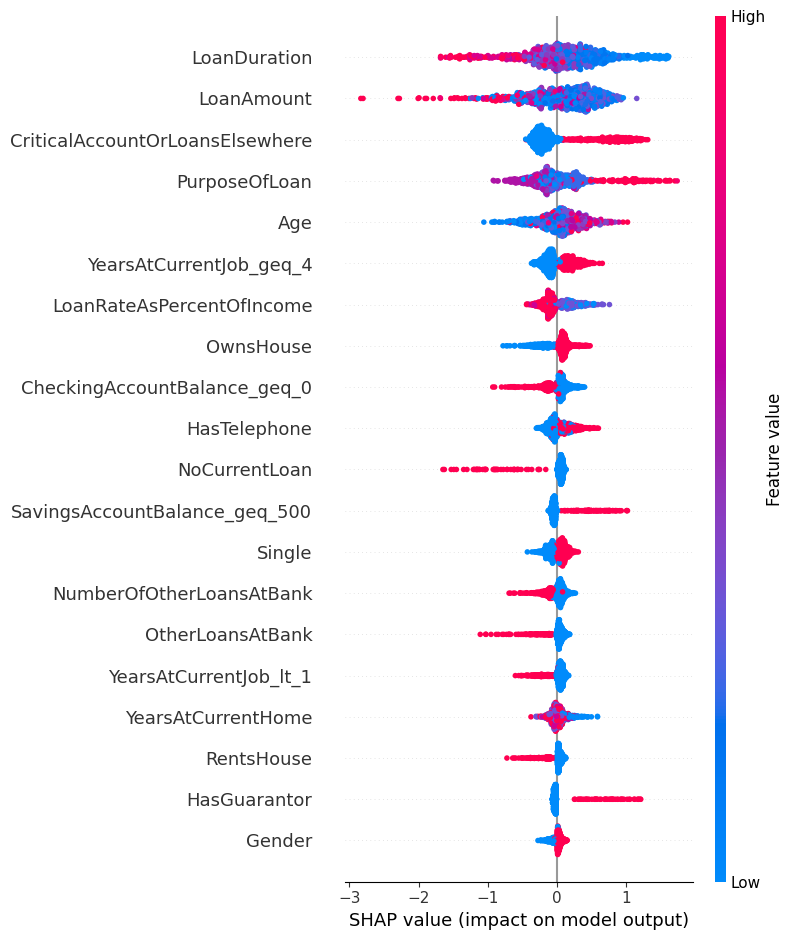

In [16]:
shap.summary_plot(shap_values, X)

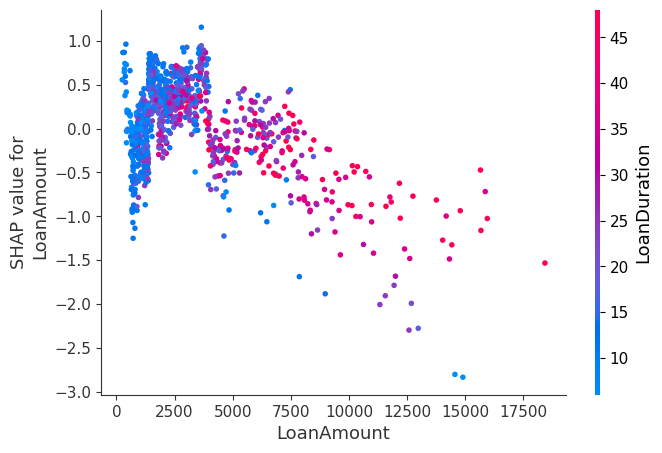

In [38]:
shap.dependence_plot("LoanAmount", shap_values.values, X, interaction_index="LoanDuration")

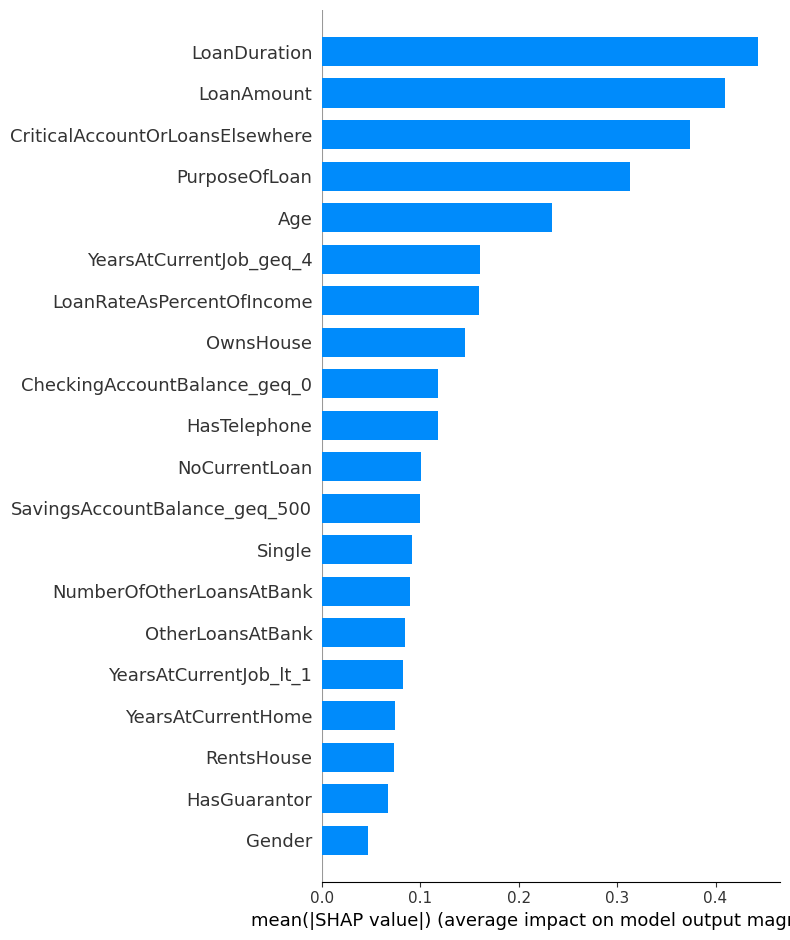

In [37]:
shap.summary_plot(shap_values, X, plot_type="bar")

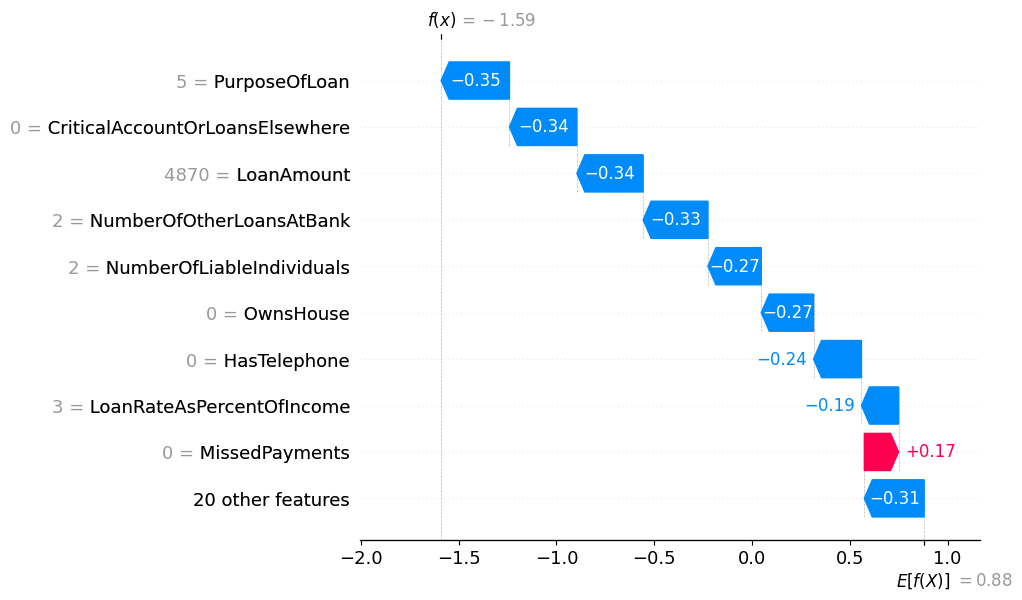

In [48]:
shap.plots.waterfall(shap_values[4])